In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
train_ds = MNIST(root='data-nn', train=True,
                 download=True, transform=ToTensor())
valid_ds = MNIST(root='data-nn', train=False,
                 download=True, transform=ToTensor())

5


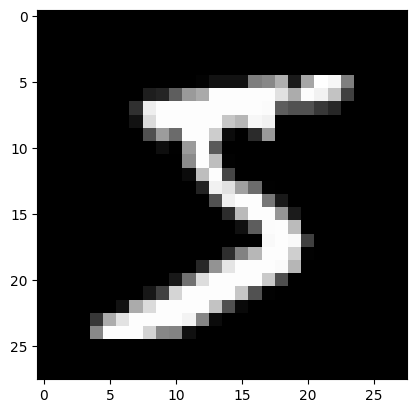

In [3]:
image, label = train_ds[0]
print(label)
plt.imshow(image.reshape(28, 28), cmap='gray')

In [4]:
# Set batch size to 64 samples per batch
bs = 64

# Create training DataLoader
# - Uses train_ds dataset created earlier
# - Loads data in batches of size bs (64)
# - shuffle=True randomly reorders data between epochs
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

# Create validation DataLoader
# - Uses valid_ds dataset created earlier
# - Same batch size as training
# - shuffle=True not strictly needed for validation but keeps consistent
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True)

In [5]:
# Import neural network module from PyTorch
from torch import nn


# Define our MNIST classifier model
class MNISTModel(nn.Module):
    def __init__(self):
        # Initialize the parent nn.Module class
        super().__init__()

        # Create a single linear layer that:
        # - Takes input of 28*28 = 784 (flattened MNIST image)
        # - Outputs 10 values (one for each digit 0-9)
        # - Linear layer applies: output = weight_matrix @ input + bias
        self.lin = nn.Linear(28 * 28, 10)

    def forward(self, xb):
        # xb shape: (batch_size, 1, 28, 28)
        # flatten all dimensions after batch dimension:
        # - Keep batch_size as first dimension
        # - Combine remaining dimensions (1, 28, 28) into 784
        # - Result shape: (batch_size, 784)
        xb = xb.flatten(1, -1)

        # Pass flattened input through linear layer
        # Output shape: (batch_size, 10)
        # Each value represents score/logit for corresponding digit
        return self.lin(xb)


# Create an instance of our model
model = MNISTModel()
# Print model architecture
print(model)

MNISTModel(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)


In [6]:
# Import PyTorch's optimization package which contains various optimizers
from torch import optim

# Learning rate - controls how big of a step we take during gradient descent
# 0.5 is relatively large but works well for this simple model
# Too small: learning is slow
# Too large: may overshoot optimal values
lr = 0.5

# CrossEntropyLoss combines:
# 1. LogSoftmax - converts raw logits to probabilities
# 2. NLLLoss - negative log likelihood loss
# Perfect for classification tasks where model outputs raw scores
loss_func = nn.CrossEntropyLoss()

# Stochastic Gradient Descent optimizer:
# - Takes model parameters that should be optimized
# - Uses learning rate (lr) to control update step size
# - At each step will update parameters: param -= lr * param.grad
optimizer = optim.SGD(model.parameters(), lr)


# Calculate classification accuracy
def accuracy_func(pred, target):
    # pred shape: (batch_size, num_classes) - raw logits/scores
    # Get predicted class by finding index of highest score for each sample
    # argmax(dim=1) operates along class dimension
    pred_class = torch.argmax(pred, dim=1)

    # Compare predicted classes with actual targets
    # Convert boolean tensor to float and take mean
    # Returns accuracy as decimal between 0 and 1
    return (pred_class == target).float().mean()

In [7]:
def train(dataloader, model, loss_func, optimizer):
    # Main training loop function that processes batches of data
    # Parameters:
    # - dataloader: Provides batches of training data
    # - model: Neural network model to train
    # - loss_func: Loss function to compute training error
    # - optimizer: Optimization algorithm (SGD) to update model weights

    for batch_idx, (xb, yb) in enumerate(dataloader):
        # Iterate through batches of data
        # batch_idx: Current batch number
        # xb: Batch of input images
        # yb: Batch of corresponding labels

        # Forward pass - get model predictions
        pred = model(xb)

        # Calculate loss between predictions and true labels
        loss = loss_func(pred, yb)

        # Backward pass - compute gradients
        loss.backward()

        # Update model parameters using optimizer
        optimizer.step()

        # Reset gradients to zero for next batch
        # Important: PyTorch accumulates gradients by default
        optimizer.zero_grad()

        # Print training statistics every 100 batches
        if batch_idx % 100 == 0:
            # Get current loss and accuracy values
            # .item() extracts value from tensor
            train_loss = loss.item()
            train_accuracy = accuracy_func(
                pred, yb).item() * 100  # Convert to percentage

            # Display current training progress
            print(f"Loss: {train_loss:6f} Accuracy: {train_accuracy:0.1f}%")

In [8]:
def test(dataloader, model, loss_func):
    # Set model to evaluation mode - important for layers like dropout and batch norm
    # This ensures they behave differently during inference vs training
    model.eval()

    # Disable gradient computation since we don't need to update weights
    # This saves memory and speeds up inference
    with torch.no_grad():
        # Iterate through batches in validation/test dataset
        for xb, yb in dataloader:
            # Forward pass - get model predictions on test data
            pred = model(xb)

            # Calculate loss between predictions and true labels
            # This helps monitor model performance
            loss = loss_func(pred, yb)

            # Calculate accuracy using our accuracy function
            # Shows percentage of correct predictions
            accuracy = accuracy_func(pred, yb)

            # Extract scalar values from tensors and convert accuracy to percentage
            # Note: This overwrites previous batches - only keeps last batch results
            # For proper test metrics, we should accumulate across all batches
            test_loss, test_accuracy = loss.item(), accuracy.item() * 100

    # Display final test metrics
    # Loss indicates how far predictions are from true values
    # Accuracy shows percentage of correct predictions
    print(f"Test Loss: {test_loss:6f} Test Accuracy: {test_accuracy:0.1f}%")

In [9]:
epochs = 2

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, model, loss_func, optimizer)
    test(valid_dl, model, loss_func)

print("Done!")

Epoch 1
-------------------------------
Loss: 2.315774 Accuracy: 7.8%
Loss: 0.506611 Accuracy: 84.4%
Loss: 0.361105 Accuracy: 89.1%
Loss: 0.349068 Accuracy: 89.1%
Loss: 0.266937 Accuracy: 93.8%
Loss: 0.306855 Accuracy: 92.2%
Loss: 0.365529 Accuracy: 90.6%
Loss: 0.307468 Accuracy: 89.1%
Loss: 0.281192 Accuracy: 92.2%
Loss: 0.263980 Accuracy: 92.2%
Test Loss: 0.282834 Test Accuracy: 87.5%
Epoch 2
-------------------------------
Loss: 0.316078 Accuracy: 93.8%
Loss: 0.393585 Accuracy: 87.5%
Loss: 0.397548 Accuracy: 87.5%
Loss: 0.169663 Accuracy: 95.3%
Loss: 0.329187 Accuracy: 90.6%
Loss: 0.380878 Accuracy: 89.1%
Loss: 0.423783 Accuracy: 90.6%
Loss: 0.125614 Accuracy: 96.9%
Loss: 0.604748 Accuracy: 90.6%
Loss: 0.322403 Accuracy: 95.3%
Test Loss: 0.088436 Test Accuracy: 93.8%
Done!
